In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt




C:\Users\Wilson\AppData\Local\Temp\ipykernel_5296\1225607800.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load data
data = pd.read_csv('C:/Users/Wilson/Desktop/TB2/Dataminiproject/Dataset/UoB_Set01_2025-01-02tapes.csv', header=None, names=['seconds', 'transaction_price', 'number_of_transactions'])

# Convert 'seconds' to timedelta and add it to the starting timestamp
data['timestamp'] = pd.to_timedelta(data['seconds'], unit='s') + pd.Timestamp('2025-01-02 00:00')

# Set 'timestamp' as the index
data.set_index(keys='timestamp', inplace=True)

# Resample data and fill missing values
data_resampled = data['transaction_price'].resample('1S').mean().fillna(method='ffill').dropna()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_resampled.values.reshape(-1,1))

C:\Users\Wilson\AppData\Local\Temp\ipykernel_5296\77767389.py:11: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data_resampled = data['transaction_price'].resample('1S').mean().fillna(method='ffill').dropna()
C:\Users\Wilson\AppData\Local\Temp\ipykernel_5296\77767389.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_resampled = data['transaction_price'].resample('1S').mean().fillna(method='ffill').dropna()


In [3]:
# Define a function to create dataset
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Define look_back
look_back = 1

# Create dataset
X, Y = create_dataset(scaled_data, look_back)

# Reshape X for LSTM
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

# Split data into train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = Y[0:train_size], Y[train_size:len(Y)]


In [4]:
# Define and compile the model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
model.fit(trainX, trainY, epochs=50, batch_size=128, verbose=2)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)







Epoch 1/50

192/192 - 1s - loss: 0.3076 - 1s/epoch - 7ms/step
Epoch 2/50
192/192 - 0s - loss: 0.0696 - 198ms/epoch - 1ms/step
Epoch 3/50
192/192 - 0s - loss: 0.0318 - 188ms/epoch - 979us/step
Epoch 4/50
192/192 - 0s - loss: 0.0267 - 182ms/epoch - 948us/step
Epoch 5/50
192/192 - 0s - loss: 0.0217 - 179ms/epoch - 932us/step
Epoch 6/50
192/192 - 0s - loss: 0.0166 - 177ms/epoch - 922us/step
Epoch 7/50
192/192 - 0s - loss: 0.0118 - 176ms/epoch - 917us/step
Epoch 8/50
192/192 - 0s - loss: 0.0075 - 177ms/epoch - 922us/step
Epoch 9/50
192/192 - 0s - loss: 0.0044 - 179ms/epoch - 932us/step
Epoch 10/50
192/192 - 0s - loss: 0.0026 - 181ms/epoch - 943us/step
Epoch 11/50
192/192 - 0s - loss: 0.0018 - 181ms/epoch - 942us/step
Epoch 12/50
192/192 - 0s - loss: 0.0016 - 182ms/epoch - 948us/step
Epoch 13/50
192/192 - 0s - loss: 0.0015 - 185ms/epoch - 964us/step
Epoch 14/50
192/192 - 0s - loss: 0.0015 - 178ms/epoch - 927us/step
Epoch 15/50
192/192 - 0s - loss: 0.0015 - 179ms/epoch - 932us/step
Epoch 16

In [5]:
# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [6]:
# Calculate RMSE for training data
train_rmse = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (train_rmse))

# Calculate RMSE for test data
test_rmse = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (test_rmse))

Train RMSE: 2.29
Test RMSE: 2.29


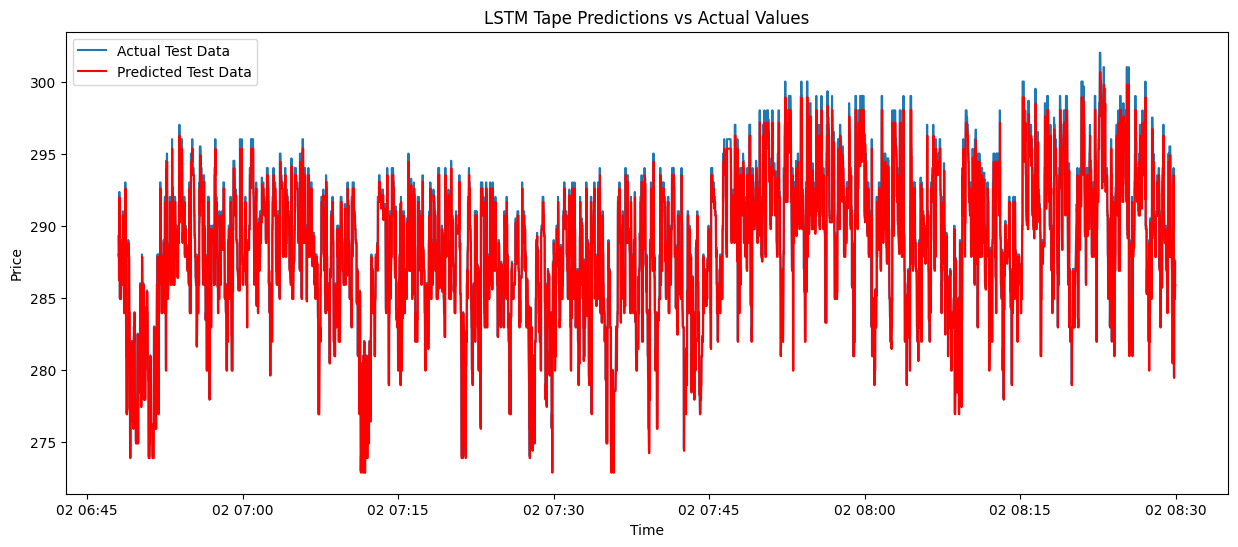

In [7]:
# Plotting
plt.figure(figsize=(15, 6))

# Use the timestamp range corresponding to the test data for x-axis
timestamps = data_resampled.index[train_size+look_back:train_size+look_back+len(testPredict)]

plt.plot(timestamps, testY[0], label='Actual Test Data')
plt.plot(timestamps, testPredict.flatten(), label='Predicted Test Data', color='red')
plt.legend()
plt.title('LSTM Tape Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()


In [8]:
# Create a DataFrame with timestamps and predicted prices
predictions_df = pd.DataFrame({'Timestamp': timestamps, 'Predicted_Price': testPredict.flatten()})

# Export the DataFrame to a CSV file
predictions_df.to_csv('test_predictions.csv', index=False)
